In [127]:
import os
import json

In [138]:
reflection_list = []
reflection_path = os.path.join('./reflect_responses')
reflection_list = os.listdir(reflection_path)
print(reflection_list)

['problem_0338.json', 'problem_0162.json', 'problem_0272.json', 'problem_0202.json', 'problem_0392.json', 'problem_0319.json', 'problem_0057.json', 'problem_0260.json', 'problem_0385.json', 'problem_0499.json', 'problem_0187.json', 'problem_0176.json', 'problem_0068.json', 'problem_0263.json', 'problem_0473.json', 'problem_0380.json', 'problem_0105.json', 'problem_0374.json', 'problem_0479.json', 'problem_0354.json', 'problem_0390.json', 'problem_0047.json', 'problem_0124.json', 'problem_0320.json', 'problem_0217.json', 'problem_0475.json', 'problem_0181.json', 'problem_0129.json', 'problem_0456.json', 'problem_0072.json', 'problem_0193.json', 'problem_0386.json', 'problem_0298.json', 'problem_0005.json', 'problem_0216.json', 'problem_0414.json', 'problem_0157.json', 'problem_0426.json', 'problem_0121.json', 'problem_0464.json', 'problem_0411.json', 'problem_0423.json', 'problem_0144.json', 'problem_0353.json', 'problem_0153.json', 'problem_0219.json', 'problem_0244.json', 'problem_017

In [129]:
import re

for response in reflection_list:
    idx = [m.start() for m in re.finditer(r'(?i)wait', response['response'])]
    print(idx)
    break

[118, 257, 404, 822, 961, 1100, 1239, 1262, 1547, 1686, 1825, 1964, 1987, 2283, 2422, 2561, 2584, 2880, 3019, 3158, 3181, 3470]


In [130]:
with open('reflect_responses/problem_0000.json', 'r') as f:
    res = json.load(f)


In [131]:
import torch
h = torch.load('hidden_state/problem_0000.pt')
len(h)

/tmp/ipykernel_166813/76448036.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  h = torch.load('hidden_state/problem_0000.pt')


1000

/tmp/ipykernel_166813/4166140853.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hidden_state = torch.load(os.path.join(hidden_state_path, path))


(42, 1536)


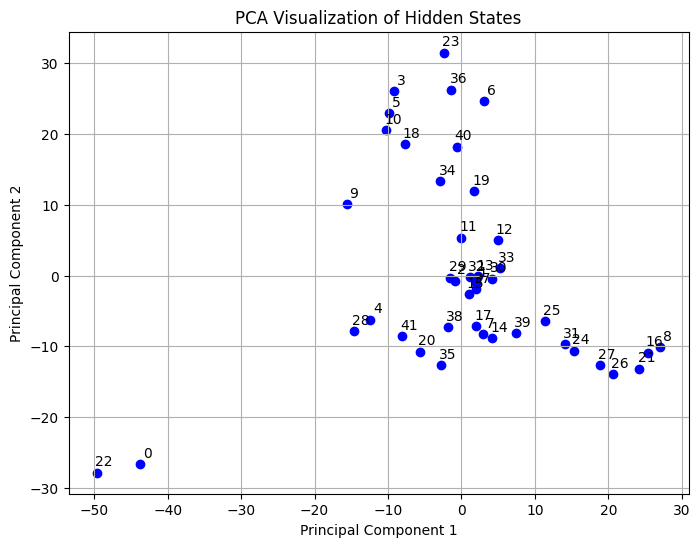

In [149]:
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
hidden_state_path = os.path.join('./hidden_state')
reflection_path = os.path.join('./reflect_responses')
idy = 0
layers = 29
interested_hidden_states = []
for path in os.listdir(hidden_state_path):
    idy += 1
    if idy > 10:
        break
    hidden_state = torch.load(os.path.join(hidden_state_path, path))
    path = path.split('.')[0] + '.json'
    with open(os.path.join(reflection_path, path), 'r') as f:
        response = json.load(f)
    input_ids = tokenizer(response['response'], return_tensors="pt")['input_ids'].to("cuda:0")
    problem_length = tokenizer(response['problem'], return_tensors="pt")['input_ids'].shape[1]
    wait_word = ['wait', 'Wait', ' wait', ' Wait']
    wait_list = []
    for word in wait_word:
        wait_list.append(tokenizer(word, return_tensors="pt")['input_ids'][0][1].item())
    indices = []
    for word in wait_list:
        index = (input_ids[0] == word).nonzero().squeeze()
        if index.dim() == 0:  # if it's a scalar, add a dimension
            index = index.unsqueeze(0)
        indices.append(index)
    res = torch.cat(indices)
    res -= problem_length + 1
    layers = 1
    for layer in range(layers):
        for idx in res:
            if idx >= 0:
                interested_hidden_states.append(h[idx][5].squeeze())

# Stack the hidden states into a matrix (each row is one hidden state)
hidden_matrix = torch.stack(interested_hidden_states).cpu().numpy()

# Apply PCA, here we extract 2 principal components for example
pca = PCA(n_components=2)
print(hidden_matrix.shape)
hidden_pca = pca.fit_transform(hidden_matrix)

plt.figure(figsize=(8, 6))

plt.scatter(hidden_pca[:, 0], hidden_pca[:, 1], color='blue')

# Annotate each point with its index
for i in range(hidden_pca.shape[0]):
    plt.annotate(str(i), (hidden_pca[i, 0], hidden_pca[i, 1]),
                textcoords="offset points", xytext=(5,5), ha='center')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Hidden States')
plt.grid(True)
plt.show()
        